## Import

In [ ]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential, load_model
from keras.layers import Conv1D, ZeroPadding1D, AveragePooling1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [ ]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Load dataframes

In [ ]:
pd.set_option('io.hdf.default.format', 'table')

x_train_arr = list()
for key in training_files:
    x_train_arr.append(pd.read_hdf(f"../../data/preprocessed_data/train_arr_{AMOUNT_OF_SENSORS}.h5", f"df{key}"))

x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    x_test_dict[key] = pd.read_hdf(f"../../data/preprocessed_data/test_dict_{AMOUNT_OF_SENSORS}.h5", f"df{key}")
    y_test = x_test_dict[key]["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    y_test_dict[key] = y_test

x_train = pd.concat([df.drop([' TimeStamp (s)', 'Pose'],axis=1) for df in x_train_arr])
y_train = pd.concat([df['Pose'] for df in x_train_arr])
x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]


## Adjust dataframes

In [ ]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

# Change shape for CNN
x_train_numpy = x_train_numpy.reshape(x_train_numpy.shape[0],x_train_numpy.shape[1], 1)
x_test_numpy = x_test_numpy.reshape(x_test_numpy.shape[0],x_test_numpy.shape[1], 1)

## Hyperparams

In [ ]:
EPOCH = 60
BATCH_SIZE = 192 # 160
LR = 0.000005 #0.000005
OPTIM = Adam(learning_rate=LR)
#OPTIM = RMSprop(learning_rate=LR)

# Shapes
INPUT_SHAPE = (x_train_numpy.shape[1], 1)
OUTPUT_SHAPE = 9

## Model

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=INPUT_SHAPE))
#model.add(Conv1D(128, kernel_size=4, padding="same", activation=activations.relu))
model.add(Conv1D(64, kernel_size=4, padding="same", activation=activations.relu))
model.add(Conv1D(32, kernel_size=4, padding="same", activation=activations.relu))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=(2))) #2
model.add(Flatten())
model.add(Dense(64, activation=activations.relu))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_SHAPE, activation=activations.softmax))
model.summary()
model.compile(optimizer=OPTIM, loss=CategoricalCrossentropy(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 39, 1)             4         
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 128)           640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 64)            32832     
_________________________________________________________________
dropout (Dropout)            (None, 39, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

## Fit the model

In [ ]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)

Epoch 1/50
2433/2433 [==============================] - 217s 88ms/step - loss: 2.1765 - accuracy: 0.1898 - val_loss: 2.1030 - val_accuracy: 0.3317
Epoch 2/50
2433/2433 [==============================] - 214s 88ms/step - loss: 1.9733 - accuracy: 0.3744 - val_loss: 1.8411 - val_accuracy: 0.4911
Epoch 3/50
2433/2433 [==============================] - 215s 88ms/step - loss: 1.6273 - accuracy: 0.4909 - val_loss: 1.5246 - val_accuracy: 0.5942
Epoch 4/50
2433/2433 [==============================] - 214s 88ms/step - loss: 1.3189 - accuracy: 0.5940 - val_loss: 1.2579 - val_accuracy: 0.6011
Epoch 5/50
2433/2433 [==============================] - 215s 88ms/step - loss: 1.0761 - accuracy: 0.6737 - val_loss: 1.0590 - val_accuracy: 0.6449
Epoch 6/50
2433/2433 [==============================] - 214s 88ms/step - loss: 0.8936 - accuracy: 0.7325 - val_loss: 0.8890 - val_accuracy: 0.7207
Epoch 7/50
2433/2433 [==============================] - 218s 90ms/step - loss: 0.7449 - accuracy: 0.7803 - val_loss: 0

## Visualise the loss

<AxesSubplot:>

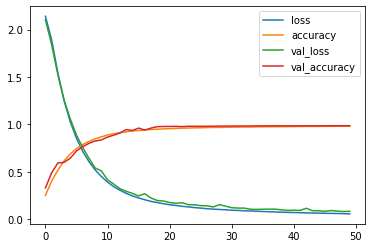

In [ ]:
history = pd.DataFrame(model.history.history)
history.plot()

## Precision

In [ ]:
print("Classification accuracy:")
classification_dict = dict()
accuracy_list = list() 

for key in x_test_dict:
    x_numpy = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1).values
    x_numpy = x_numpy.reshape(x_numpy.shape[0],x_numpy.shape[1], 1)
    classify = model.predict(x_numpy)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
    print(f"{key}: {accuracy_list[-1]}%")
    classification_dict[key] = classifications

print(f"Average accuracy: {round(sum(accuracy_list)/len(accuracy_list),2)}%")

Classification accuracy:
001: 78.63%
002: 80.06%
004: 94.01%
005: 95.84%
006: 93.42%
007: 85.16%
009: 85.68%
010: 99.58%
Average accuracy: 89.05%
Classification accuracy:
001: 83.83%
002: 73.43%
004: 96.09%
005: 97.82%
006: 87.49%
007: 84.41%
009: 88.72%
010: 99.6%
Average accuracy: 88.92%
Classification accuracy:
001: 86.73%
002: 77.67%
004: 98.9%
005: 97.5%
006: 84.8%
007: 79.89%
009: 89.9%
010: 90.62%
Average accuracy: 88.25%


## Visualise classification

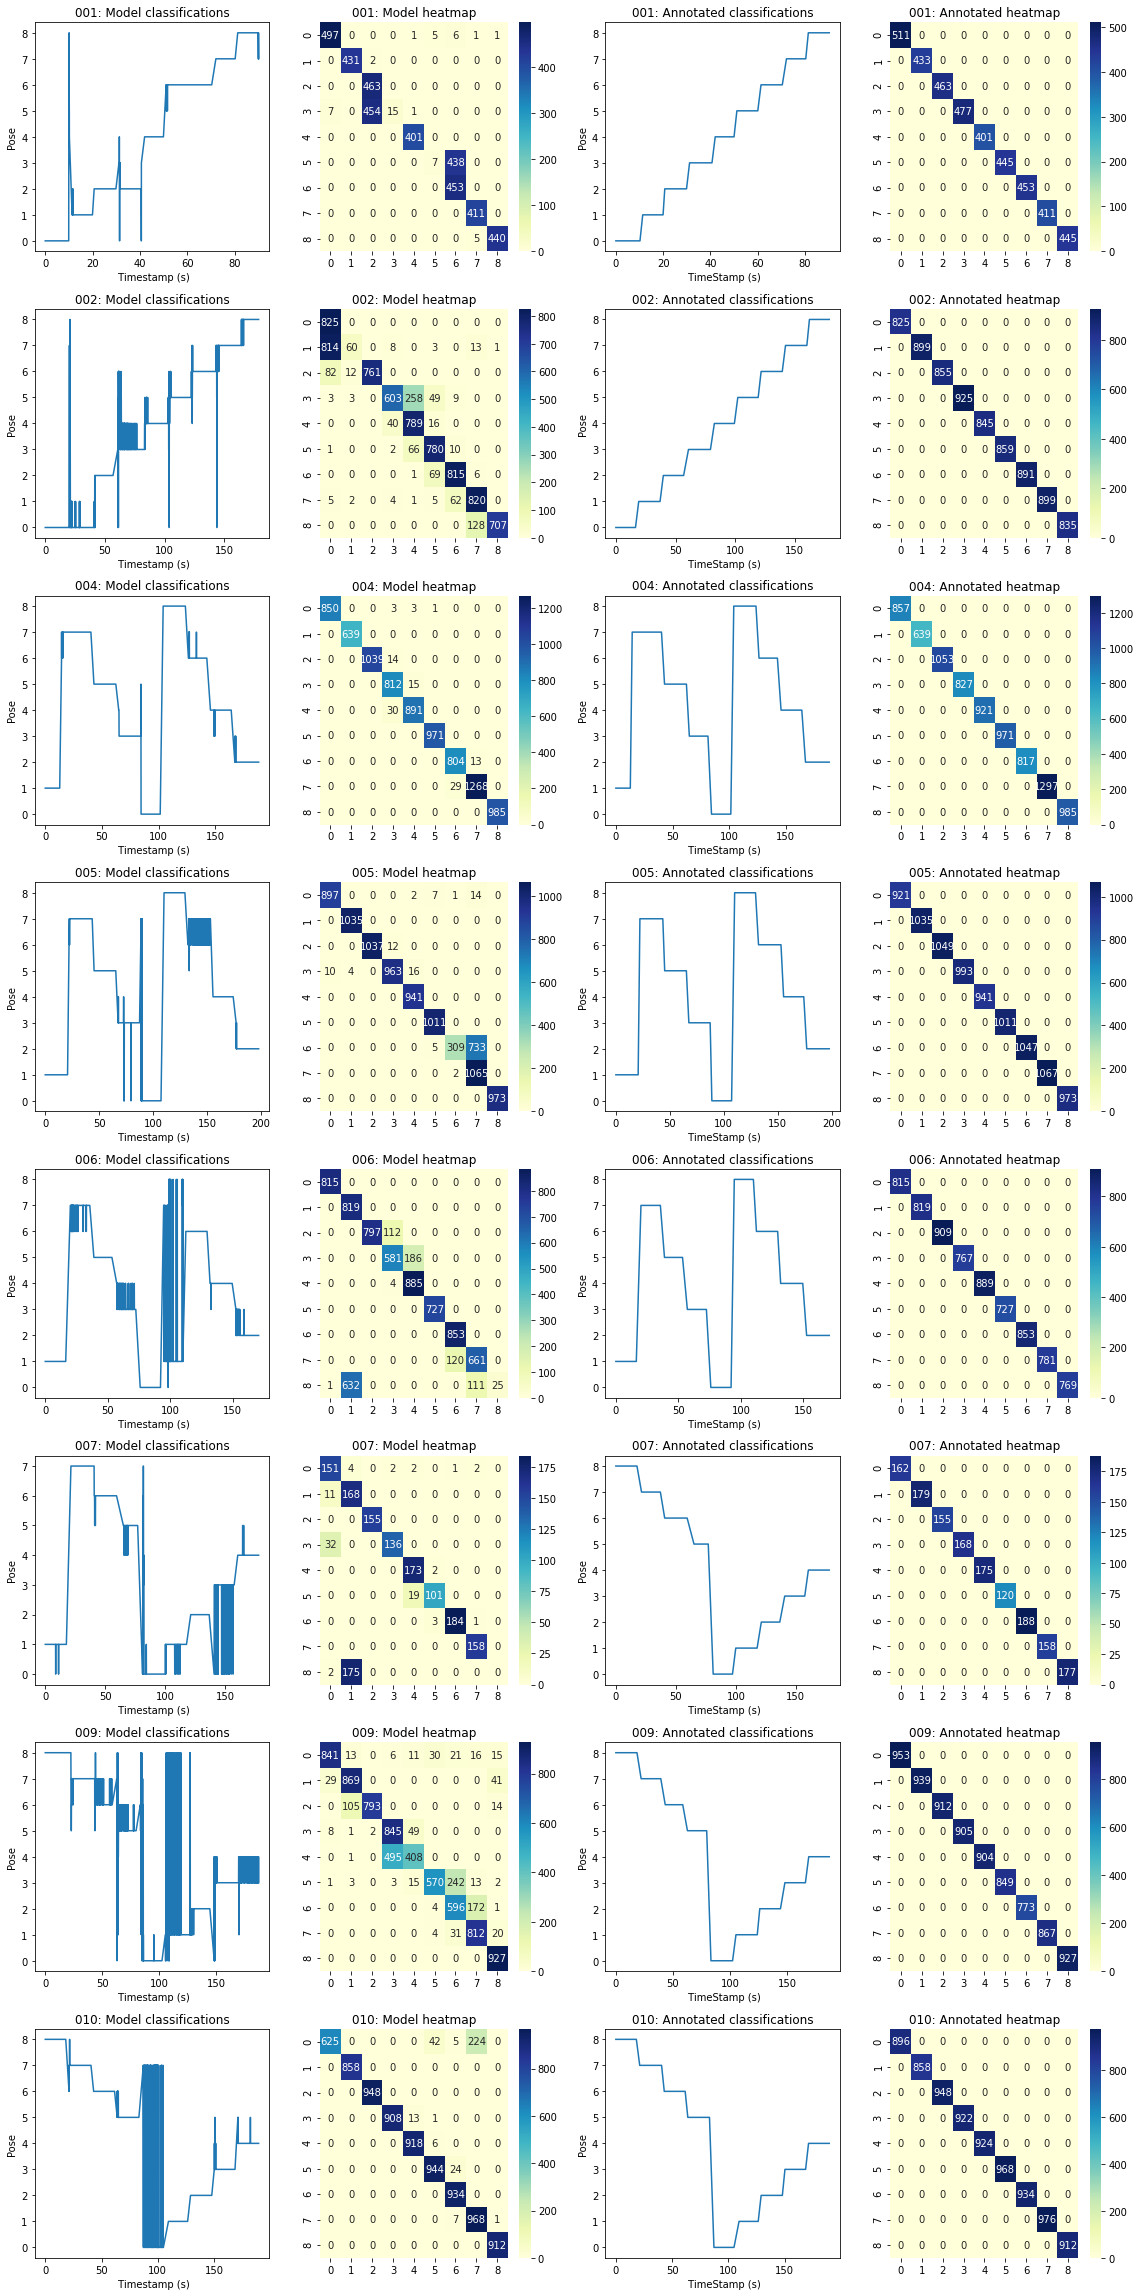

In [ ]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

In [ ]:
path = f"../models/CNN_{AMOUNT_OF_SENSORS}_sensor{'er' if AMOUNT_OF_SENSORS > 1}.h5"
model.save(path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>